In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # Disable the warning
from scipy.stats import norm
import matplotlib.ticker as ticker
%matplotlib widget

In [17]:
hits = pd.read_hdf(f"../config/ATPC_0nubb.h5", 'MC/hits')

display(hits)

,event_id,x,y,z,time,energy,label,particle_id,hit_id
0,0,1908.942505,1202.253174,854.039551,0.002031,0.010386,GAS,2,0
1,0,1908.579590,1202.741577,854.280029,0.004877,0.035060,GAS,2,1
2,0,1908.208008,1202.276367,854.219360,0.007571,0.017007,GAS,2,2
3,0,1908.646118,1202.054932,854.502075,0.010172,0.027088,GAS,2,3
4,0,1908.971924,1201.868164,854.843689,0.012586,0.019201,GAS,2,4
...,...,...,...,...,...,...,...,...,...
2109800,9549,1903.948608,-811.297546,45.796902,0.007654,0.003683,GAS,1,13
2109801,9549,1903.952515,-811.306763,45.804741,0.007813,0.005289,GAS,1,14
2109802,9549,1903.947266,-811.303223,45.809380,0.007926,0.003913,GAS,1,15
2109803,9549,1903.951904,-811.304199,45.808777,0.008007,0.004531,GAS,1,16


In [60]:
# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 24.8e-6 # [eV]

# Function to smear the number of electrons in each hit by the fano factor
def smear_energy(N, resolution):
    if N < 10:
        return np.random.poisson(N)  # Poisson for small N
    else:
        # sigma = np.sqrt(N * 0.15) # 0.15 Fano factor
        if (resolution == 1):
            sigma = np.sqrt(N * 1.8) # 1% ER
        
        elif (resolution == 1.2):
            sigma = np.sqrt(N * 2.6) # 1.2% ER
        
        elif (resolution == 0.3):
            sigma = np.sqrt(N * 0.15) # 0.3% ER
        
        elif (resolution == 0.75):
            sigma = np.sqrt(N * 0.98) # 0.75% ER
        
        elif (resolution == 0.5):
            sigma = np.sqrt(N * 0.45) # 0.5% ER
        else:
            print("Error resoltion not defined, using default 1%")
            sigma = np.sqrt(N * 1.8) # 1% ER
        
        new_n = int(round(np.random.normal(N, sigma)))
        if (new_n < 0):
            return 1
        else:
            return new_n  # Apply Gauss+rounding

In [61]:
def FilterEventE(df, Emin, Emax, E_mean):

    event_energies = df.groupby("event_id").n.sum()*E_mean*1000

    passed_events = event_energies[ (event_energies >= Emin) & ((event_energies <= Emax))].index

    dfs_filtered = df[df["event_id"].isin(passed_events)]

    return dfs_filtered

In [62]:
e_sum = []

dfs = []
dfs2 = []
dfs3 = []
dfs4 = []
dfs5 = []

for index, e in enumerate(hits.event_id.unique()):
    print("On Event:", e )

    if (e > 10000):
        break

    # Select the event
    event = hits[hits.event_id == e]

    # Calc number of electrons in a hit
    event["n"] = round(event["energy"]/E_mean)
    event2 = event.copy()
    event3 = event.copy()
    event4 = event.copy()
    event5 = event.copy()
    
    # Smear the energy by Fano amount
    event["n"]  = event["n"].apply(lambda x: smear_energy(x, resolution=1))
    # event2["n"] = event2["n"].apply(lambda x: smear_energy(x, resolution=0.5))
    # event3["n"] = event3["n"].apply(lambda x: smear_energy(x, resolution=1.2))
    # event4["n"] = event4["n"].apply(lambda x: smear_energy(x, resolution=0.3))
    event5["n"] = event5["n"].apply(lambda x: smear_energy(x, resolution=0.75))
    
    dfs.append(event)
    dfs2.append(event2)
    dfs3.append(event3)
    dfs4.append(event4)
    dfs5.append(event5)


dfs = pd.concat(dfs)
dfs2 = pd.concat(dfs2)
dfs3 = pd.concat(dfs3)
dfs4 = pd.concat(dfs4)
dfs5 = pd.concat(dfs5)
display(dfs)


On Event: 0
On Event: 1
On Event: 2
On Event: 3
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
On Event: 10
On Event: 11
On Event: 12
On Event: 13
On Event: 14
On Event: 15
On Event: 16
On Event: 17
On Event: 18
On Event: 19
On Event: 20
On Event: 21
On Event: 22
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
On Event: 40
On Event: 41
On Event: 42
On Event: 43
On Event: 44
On Event: 45
On Event: 46
On Event: 47
On Event: 48
On Event: 49
On Event: 50
On Event: 51
On Event: 52
On Event: 53
On Event: 54
On Event: 55
On Event: 56
On Event: 57
On Event: 58
On Event: 59
On Event: 60
On Event: 61
On Event: 62
On Event: 63
On Event: 64
On Event: 65
On Event: 66
On Event: 67
On Event: 68
On Event: 69
On Event: 70
On Event: 71
On Event: 72
On Event: 73
On Event: 74
On Event: 75
On Event: 76
On Event:

,event_id,x,y,z,time,energy,label,particle_id,hit_id,n
0,0,1908.942505,1202.253174,854.039551,0.002031,0.010386,GAS,2,0,415
1,0,1908.579590,1202.741577,854.280029,0.004877,0.035060,GAS,2,1,1318
2,0,1908.208008,1202.276367,854.219360,0.007571,0.017007,GAS,2,2,685
3,0,1908.646118,1202.054932,854.502075,0.010172,0.027088,GAS,2,3,1181
4,0,1908.971924,1201.868164,854.843689,0.012586,0.019201,GAS,2,4,765
...,...,...,...,...,...,...,...,...,...,...
2109800,9549,1903.948608,-811.297546,45.796902,0.007654,0.003683,GAS,1,13,133
2109801,9549,1903.952515,-811.306763,45.804741,0.007813,0.005289,GAS,1,14,210
2109802,9549,1903.947266,-811.303223,45.809380,0.007926,0.003913,GAS,1,15,178
2109803,9549,1903.951904,-811.304199,45.808777,0.008007,0.004531,GAS,1,16,212


In [ ]:

Eres = 0.75

min_E = 2458 - Eres*2458/100
max_E = 2458 + Eres*2458/100
print(min_E, max_E)

if (Eres == 1):
    filt_df = dfs
elif (Eres == 0.5):
    filt_df = dfs2
elif (Eres == 1.2):
    filt_df = dfs3
elif (Eres == 0.3):
    filt_df = dfs4
elif (Eres == 0.75):
    filt_df = dfs5


    
# filt_df = FilterEventE(dfs, min_E, max_E, E_mean)


# filt_df = pd.read_hdf("../config/ATPC_0nubb_EFilt.h5", "MC/hits5")

# event_energies = dfs.groupby("event_id").n.sum()*E_mean*1000
event_energies = filt_df.groupby("event_id").n.sum()*E_mean*1000
print(event_energies)



2439.565 2476.435
event_id
0       2458.1016
1       2455.1504
2       2460.4824
3       2458.5976
4       2452.6704
          ...    
9004    2456.4896
9005    2458.1512
9006    2459.2176
9007    2455.6216
9008    2459.9368
Name: n, Length: 8778, dtype: float64


FWMH: 6.710496510564363
Eres FWMH: 0.2730189130581593


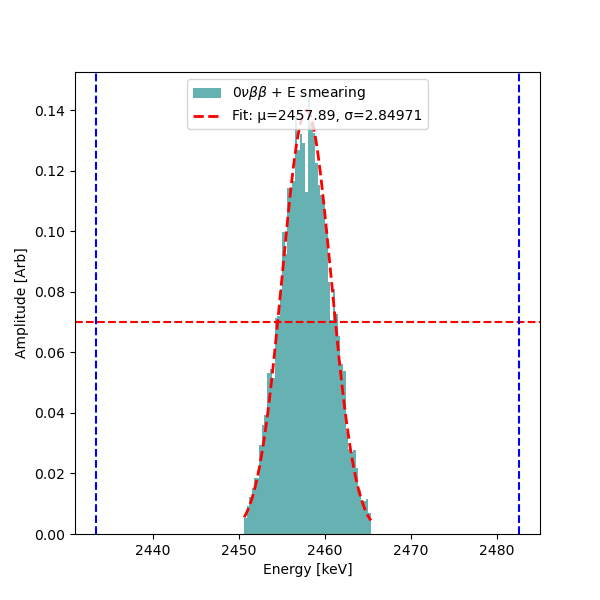

In [78]:
fig = plt.figure(figsize=(6,6));

plt.subplot(111);
# Plot histogram
counts, bins, _ = plt.hist(event_energies, bins=50, density=True, alpha=0.6, color='Teal', label=r'$0\nu\beta\beta$ + E smearing')
mu, sigma = norm.fit(event_energies)


# Plot the fitted Gaussian curve
x = np.linspace(bins[0], bins[-1], 200)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.5f}')
plt.xlabel('Energy [keV]')
plt.ylabel("Amplitude [Arb]")
plt.legend()

print("FWMH:", 2.3548*sigma)
print("Eres FWMH:", 100*2.3548*sigma/mu)

plt.axhline(y=max(pdf)/2.0, color='r', linestyle='--')

plt.axvline(x=2.43342*1000, color='b', linestyle='--')
plt.axvline(x=2.48258*1000, color='b', linestyle='--')

# plt.savefig(f"plots/Technote/ERes_0.5percent.pdf", dpi=500)


In [164]:
# Make a plot of the background acceptance vs signal efficiency
N_sig = 10000.
N_Bi  = 10.e6
N_Tl  = 1.e6
N_single = 100e3
E_mean = 24.8e-6 # [eV]

nubb_meta = pd.read_hdf("../data/Eres/ATPC_0nubb_Efilt.h5", "MC/meta")
Bi_meta = pd.read_hdf("../data/Eres/ATPC_Bi_ion_Efilt.h5", "MC/meta")
Tl_meta = pd.read_hdf("../data/Eres/ATPC_Tl_ion_Efilt.h5", "MC/meta")
single_meta = pd.read_hdf("../data/Eres/ATPC_single_Efilt.h5", "MC/meta")

display(nubb_meta)
display(Bi_meta)
display(Tl_meta)
display(single_meta)


N_sig_win = int(nubb_meta.N_saved.iloc[0])
N_Bi_win  = int(Bi_meta.N_saved.iloc[0])
N_Tl_win  = int(Tl_meta.N_saved.iloc[0])
N_single_win  = int(single_meta.N_saved.iloc[0])
print(N_sig_win, N_Bi_win, N_Tl_win)

def LoadHits(file):
    hits1 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits1")
    hits2 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits2")
    hits3 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits3")
    hits4 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits4")
    hits5 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits5")

    hits1["energy"] = hits1["n"]*E_mean
    hits2["energy"] = hits2["n"]*E_mean
    hits3["energy"] = hits3["n"]*E_mean
    hits4["energy"] = hits4["n"]*E_mean
    hits5["energy"] = hits5["n"]*E_mean
    return [hits1, hits2, hits3, hits4, hits5]


# Cut out events with Brem in the name
def ApplyEnergyWindowCut(df,threshold):

    event_energy = df.groupby("event_id").energy.sum()
    good_events = event_energy[(event_energy >= threshold) & (event_energy <= 2.5)].index
    df = df[df["event_id"].isin(good_events)]
    return df


def ApplyVariedEnergyThreshold(df, Eres):

    thresh_range = np.arange(1, -0.1, -0.1)

    wins = []
    for r in thresh_range:

        threshold = 2.458 - r * Eres*2.458/100
        df = ApplyEnergyWindowCut(df,threshold)
        wins.append(len(df.event_id.unique()))

    return np.array(wins)


nubb_hits   = LoadHits("ATPC_0nubb_Efilt.h5")
Bi_hits = LoadHits("ATPC_Bi_ion_Efilt.h5")
Tl_hits = LoadHits("ATPC_Tl_ion_Efilt.h5")
single_hits = LoadHits("ATPC_single_Efilt.h5")

Eres = [1.2, 1.0, 0.75, 0.5, 0.3]


nubb_win = []
Bi_win = []
Tl_win = []
single_win = []

for index, res in enumerate(Eres):
    print("On resolution", res)
    # nubb_win.append(ApplyVariedEnergyThreshold(nubb_hits[index], res)/N_sig)
    # Bi_win.append  (0.37*ApplyVariedEnergyThreshold(Bi_hits[index], res)/N_Bi)
    # Tl_win.append  (0.37*ApplyVariedEnergyThreshold(Tl_hits[index], res)/N_Tl)
    nubb_win.append(ApplyVariedEnergyThreshold(nubb_hits[index], res)/N_sig_win)
    Bi_win.append  (0.37*ApplyVariedEnergyThreshold(Bi_hits[index], res)/N_Bi_win)
    Tl_win.append  (0.37*ApplyVariedEnergyThreshold(Tl_hits[index], res)/N_Tl_win)
    single_win.append  (ApplyVariedEnergyThreshold(single_hits[index], res)/N_single_win)


print(nubb_win[1])
print(Bi_win[1])
print(Tl_win[1])
print(single_win[1])




,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,10000,9009,8753,8765,8742,8730,8778,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,0


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,10000000,5465,3886,3714,3388,2568,705,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,9800


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,1000000,10548,1861,1526,1120,751,452,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,9800


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,100000,9628,1925,1608,1235,840,493,2.3 MeV,2.6 MeV,25 bar,2.114 m,4 cm,9800,0


9009 5465 10548
On resolution 1.2
On resolution 1.0
On resolution 0.75
On resolution 0.5
On resolution 0.3
[0.97291597 0.96359196 0.94838495 0.92907093 0.8997669  0.85614386
 0.80530581 0.74270174 0.66389166 0.57531358 0.48606949]
[0.25145105 0.24034767 0.22538518 0.20710522 0.18442452 0.15978042
 0.1347301  0.11123696 0.09018115 0.07034401 0.05233486]
[0.05352863 0.05082765 0.04767065 0.0453906  0.04258438 0.03991847
 0.03721748 0.03413064 0.03132442 0.02827266 0.02546644]
[0.16701288 0.15797673 0.15070627 0.14229331 0.13419194 0.12494807
 0.11746988 0.10874533 0.09991691 0.09171167 0.08340258]


0.9715839715839716


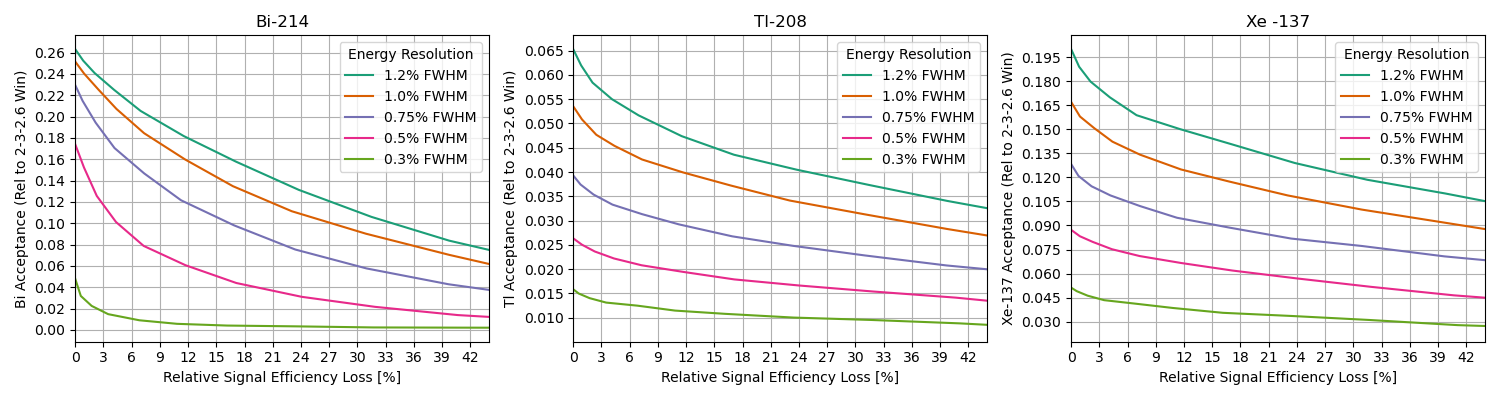

In [167]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Dark2.colors)
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

print(nubb_win[0][0])

for index, res in enumerate(Eres):
    ax[0].plot(nubb_win[index][0]*100 - nubb_win[index]*100, Bi_win[index], label = f"{res}% FWHM")
    ax[1].plot(nubb_win[index][0]*100 - nubb_win[index]*100, Tl_win[index], label = f"{res}% FWHM")
    ax[2].plot(nubb_win[index][0]*100 - nubb_win[index]*100, single_win[index], label = f"{res}% FWHM")

ax[0].set_title("Bi-214")
ax[0].set_xlabel("Relative Signal Efficiency Loss [%]")
ax[0].set_ylabel("Bi Acceptance (Rel to 2-3-2.6 Win)")
# ax[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
# ax[0].ticklabel_format(style="sci", axis="y", scilimits=(0,0))
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[0].legend(title = "Energy Resolution")
ax[0].grid()
ax[0].set_xlim(0,44)

ax[1].set_title("Tl-208")
ax[1].set_xlabel("Relative Signal Efficiency Loss [%]")
ax[1].set_ylabel("Tl Acceptance (Rel to 2-3-2.6 Win)")
# ax[1].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
# ax[1].ticklabel_format(style="sci", axis="y", scilimits=(0,0))
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1].legend(title = "Energy Resolution")
ax[1].grid()
ax[1].set_xlim(0,44)

ax[2].set_title("Xe -137")
ax[2].set_xlabel("Relative Signal Efficiency Loss [%]")
ax[2].set_ylabel("Xe-137 Acceptance (Rel to 2-3-2.6 Win)")
# ax[2].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
# ax[2].ticklabel_format(style="sci", axis="y", scilimits=(0,0))
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[2].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[2].legend(title = "Energy Resolution")
ax[2].grid()
ax[2].set_xlim(0,44)
plt.tight_layout()

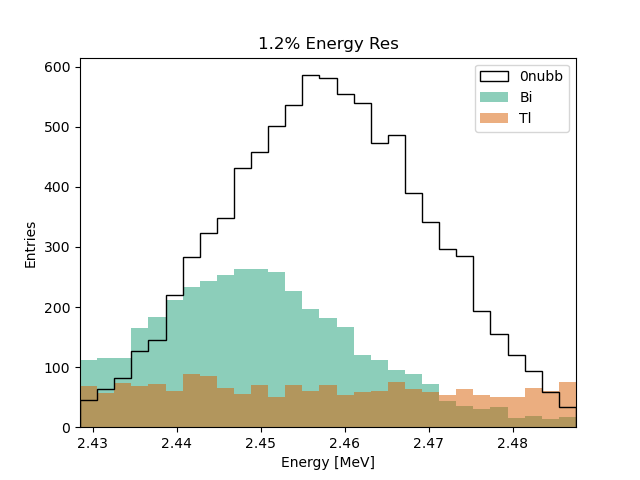

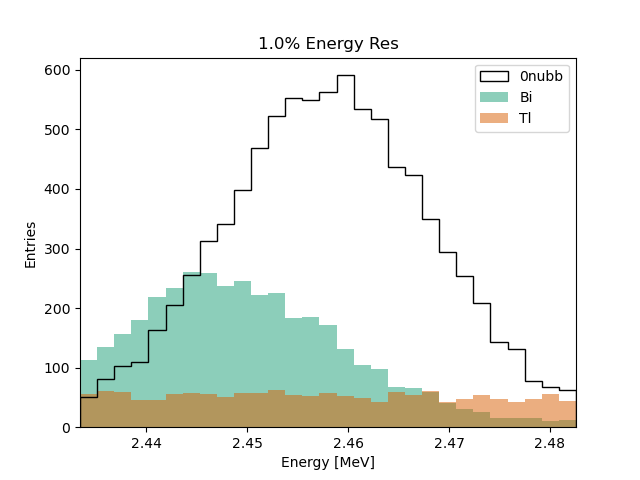

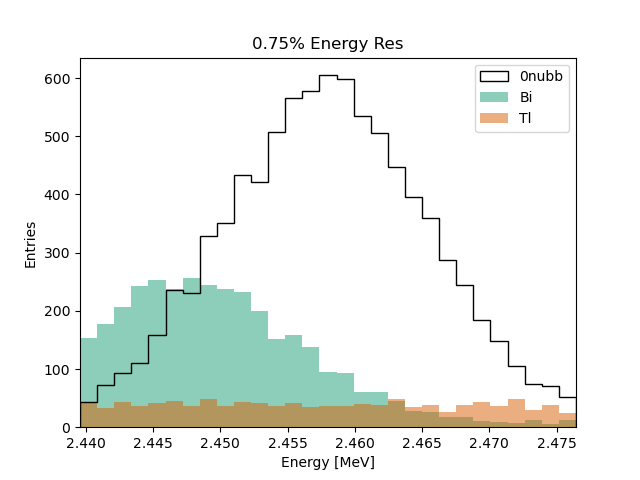

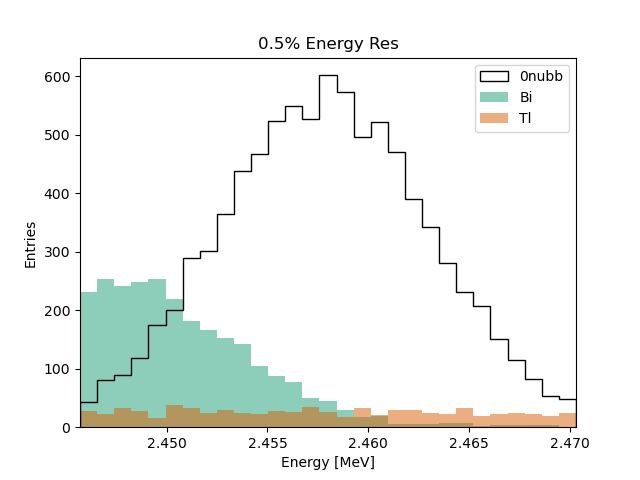

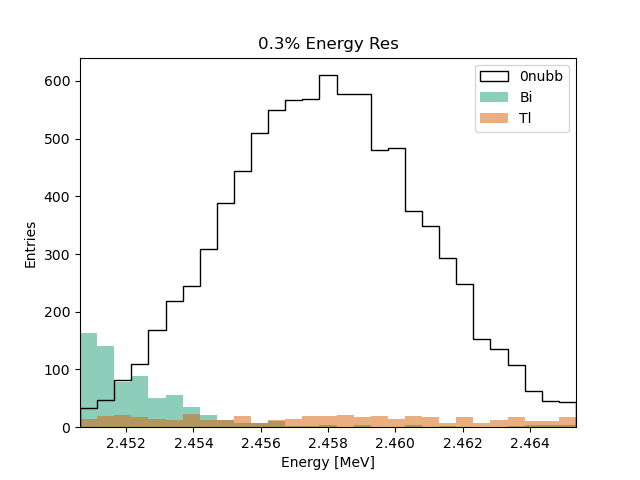

In [148]:
def ApplyVariedEnergyThresholdDF(df, Eres):

    threshold = 2.458 - Eres*2.458/100
    df = ApplyEnergyWindowCut(df,threshold)

    return df
Eres = [1.2, 1.0, 0.75, 0.5, 0.3]
for index, Eres in enumerate(Eres):
    # Eres = 1

    if (Eres == 1.2):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[0], 1.2)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[0], 1.2)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[0], 1.2)
    elif (Eres == 1):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[1], 1)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[1], 1)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[1], 1)
    elif (Eres == 0.75):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[2], 0.75)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[2], 0.75)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[2], 0.75)
    elif (Eres == 0.5):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[3], 0.5)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[3], 0.5)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[3], 0.5)
    elif (Eres == 0.3):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[4], 0.3)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[4], 0.3)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[4], 0.3)

    plt.figure()
    Emin = 2.458 - Eres*2.458/100
    Emax = 2.458 + Eres*2.458/100
    plt.hist(nubb_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), histtype = "step", label = "0nubb", color = "k");
    plt.hist(Bi_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), alpha = 0.5, label = "Bi");
    plt.hist(Tl_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), alpha = 0.5, label = "Tl");
    plt.xlabel("Energy [MeV]")
    plt.ylabel("Entries")
    plt.title(f"{Eres}% Energy Res")
    plt.xlim(Emin, Emax)

    plt.legend()